In [5]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from sklearn.model_selection import (TimeSeriesSplit)
from sklearn.linear_model import (LinearRegression, BayesianRidge, Lasso)
from sklearn.metrics import (mean_squared_error)
from sklearn.decomposition import (PCA)
from sklearn.tree import DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


This version contains the application of regression models after PCA dimensionality reduction, with k folds cross validation with blocking.

1. Get and preprocess data

In [6]:
def rename_columns(old_name):
    if old_name[-5:] == '10-10':
        new_name = old_name[:-5] + '10' 
    elif old_name[-5:] == '20-20':
        new_name = old_name[:-5] + '20' 
    else:
        new_name = old_name
    return new_name

def get_data(company):
    daily = pd.read_csv('./data/daily_{}.csv'.format(company))
    open_ind = pd.read_csv('./data/open_ind_{}.csv'.format(company))
    close_ind = pd.read_csv('./data/close_ind_{}.csv'.format(company))
    high_ind = pd.read_csv('./data/high_ind_{}.csv'.format(company))
    low_ind = pd.read_csv('./data/low_ind_{}.csv'.format(company))

    open_ind.rename(columns=rename_columns, inplace=True)
    close_ind.rename(columns=rename_columns, inplace=True)
    high_ind.rename(columns=rename_columns, inplace=True)
    low_ind.rename(columns=rename_columns, inplace=True)
    
    return daily, open_ind, close_ind, high_ind, low_ind

In [7]:
def get_process_data(company):
    data = get_data(company) #(daily, open_ind, close_ind, high_ind, low_ind)
    X_list = []
    y_list = []
    for i in range(len(price_types)):
        combined = pd.concat([data[0],data[i+1]],axis=1)
        combined = combined[combined.isnull().any(axis=1)==False] # drop any columns that has NA, some indicators do not go further back, should start around the year 2000
        combined.rename({'Unnamed: 0': 'Date','1. open':'open', '2. high': 'high', '3. low': 'low', '4. close': 'close','6. volume': 'volume', '7. dividend amount': 'dividend'}, axis='columns',inplace=True)
        combined.drop('5. adjusted close',axis=1, inplace=True)
        combined.drop('8. split coefficient',axis=1, inplace=True)
        combined.set_index('Date',inplace=True)
        combined = combined.iloc[::-1]
        
        X = combined.iloc[:,4:]
        X_list.append(X)
        y = combined[[price_types[i]]]
        y_list.append(y)
        
    return X_list,y_list

Standardize or scale using standardScaler and MinMaxScaler, perform PCA, 

In [8]:
def standardize_scale(dif_scaler, X_train, X_test, y_train, y_test):
    scaler_X=dif_scaler
    X_train_standardize = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_standardize = pd.DataFrame(scaler_X.transform(X_test),  columns=X_test.columns, index=X_test.index)
    
    scaler_Y=dif_scaler
    y_train_standardize = pd.DataFrame(scaler_Y.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
    y_test_standardize = pd.DataFrame(scaler_Y.transform(y_test), columns=y_test.columns, index=y_test.index)

    X_train_standardize.insert(0,'bias',1)
    X_test_standardize.insert(0,'bias',1)
    
    return [X_train_standardize, X_test_standardize, y_train_standardize, y_test_standardize], scaler_Y

In [9]:
# if n_steps=5, use 1,2,3,4,5th day indicator data to predict 6th day prices
def reshape_for_regression(X, y, n_steps=5):
    X_result = []
    s = X.shape[0] - n_steps
    for i in range(s):
        temp = []
        for j in range(n_steps):
            temp += list(X.iloc[i+j,:].values)
        X_result.append(temp)     # n_features x n_steps elements total in one row instead of just n_features elements
    
    y_result = y.iloc[n_steps:,:]
    return pd.DataFrame(X_result, index=X.iloc[n_steps:,:].index), y_result

In [10]:
def reshape_data(data, n_steps=5):
    X_train, X_test, y_train, y_test = data
    
    a,b = reshape_for_regression(X_train, y_train, n_steps)
    c,d = reshape_for_regression(X_test, y_test, n_steps)
    
    return a,c,b,d

In [11]:
# perform PCA to reduce dimension so reduced features can explain 95% of variance
def perform_PCA(X_train, X_test, threshold=0.95):
    pca = PCA(n_components=threshold)
    pca.fit(X_train)
    reduced_X_train = pca.transform(X_train)
    reduced_X_test = pca.transform(X_test)
    return pd.DataFrame(reduced_X_train, index=X_train.index), pd.DataFrame(reduced_X_test, index=X_test.index)

This version has "blocking time series split"

In [12]:
# k_folds for number of splits for cross validation
# n_steps for number of past data used in prediction (if 5, use 1,2,3,4,5th day data to predict 6th day)

def k_folds_and_standardize(X_list,y_list,k_folds=5, n_steps=5, PCA=True):
    ts_kfold = TimeSeriesSplit(k_folds)
    standardized_all_splits_by_price_type = []
    min_max_scaler_all_splits_by_price_type = []
    standardized_scalers_list = []
    minmax_scalers_list = []
    X_train_lists = []
    
    for index in range(len(X_list)): #open,close,high,low
        X=X_list[index]
        y=y_list[index]
        standardized_splits_by_price_type = []
        min_max_scaler_splits_by_price_type = []
        
        standardized_scalers = []
        minmax_scalers = []
        start = 0
        each_fold_size = X.shape[0]//k_folds
        X_train_list = []
        
        
#         Time Series Split - k fold
#         for train_index, test_index in ts_kfold.split(X):
#             X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#             y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        for i in range(k_folds):
            
            # blocking time series split
            if i == 0:
                fold_size = X.shape[0]%k_folds + each_fold_size
            else:
                fold_size = each_fold_size
            training_size = math.ceil(fold_size*0.75)

            X_train, X_test = X.iloc[start:start+training_size,:], X.iloc[start+training_size:start+fold_size, :]
            y_train, y_test = y.iloc[start:start+training_size,:], y.iloc[start+training_size:start+fold_size, :]
            start += fold_size
            
            # reshape with past n_steps days values
            X_train, X_test, y_train, y_test = reshape_data([X_train, X_test, y_train, y_test ], n_steps)
            
            # standardize
            standardized_data, scalers = standardize_scale(StandardScaler(), X_train, X_test, y_train, y_test)
            X_train, X_test, y_train, y_test = standardized_data
            if PCA:
                X_train, X_test = perform_PCA(X_train, X_test)
            
            standardized_splits_by_price_type.append([X_train, X_test, y_train, y_test])
            standardized_scalers.append(scalers)  # only save scalers for Y to inverse_transform the predicted result
            
            X_train_list.append(X_train)
#             min_max_data, scalers = standardize_scale(MinMaxScaler(feature_range=(0,1)), X_train, X_test, y_train, y_test)
#             X_train, X_test, y_train, y_test = min_max_data
#             X_train, X_test = perform_PCA(X_train, X_test)
            
#             min_max_scaler_splits_by_price_type.append([X_train, X_test, y_train, y_test])
#             minmax_scalers.append(scalers)  # only save scalers for Y to inverse_transform the predicted result
            
        standardized_all_splits_by_price_type.append(standardized_splits_by_price_type)
#         min_max_scaler_all_splits_by_price_type.append(min_max_scaler_splits_by_price_type)
        
        standardized_scalers_list.append(standardized_scalers)
#         minmax_scalers_list.append(minmax_scalers)
        X_train_lists.append(X_train_list)
        
#     min_max_scaler_all_splits_by_price_type, , minmax_scalers_list
    return standardized_all_splits_by_price_type, standardized_scalers_list, X_train_lists
# result will be of size (4, k_folds, 4) The outer four is the type of prices, open close high low. The inner four is the training and testing sets of X and y.

In [13]:
def linear_regression(X_train, X_test, y_train, y_test, scaler):
    linear_reg = LinearRegression().fit(X_train,y_train)
    y_predict = linear_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse

In [14]:
def bayesian_ridge_regression(X_train, X_test, y_train, y_test, scaler):
    bay_reg = BayesianRidge().fit(X_train,y_train.values.ravel())
    y_predict = bay_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [15]:
def lasso_regression(X_train, X_test, y_train, y_test, scaler):
    lasso_reg = Lasso().fit(X_train,y_train.values.ravel())
    y_predict = lasso_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [16]:
def decision_tree_regression(X_train, X_test, y_train, y_test, scaler):
    ds_reg = DecisionTreeRegressor().fit(X_train,y_train)
    y_predict = ds_reg.predict(X_test)

    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse

In [17]:
def random_forest_regression(X_train, X_test, y_train, y_test, scaler):
    rf_reg = RandomForestRegressor(random_state=0)
    rf_reg.fit(X_train, y_train)
    y_predict = rf_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [18]:
def support_vector_regression(X_train, X_test, y_train, y_test, scaler):
    svr_reg = SVR().fit(X_train, y_train)
    y_predict = svr_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [19]:
def implement_models(standardized_data, scalers, model_types, k_folds=5):
    open_RMSEs = pd.DataFrame()
    close_RMSEs = pd.DataFrame()
    high_RMSEs = pd.DataFrame()
    low_RMSEs = pd.DataFrame()

    open_predictions = pd.DataFrame()
    close_predictions = pd.DataFrame()
    high_predictions = pd.DataFrame()
    low_predictions = pd.DataFrame()
    
    open_X_train_list = []
    close_X_train_list = []
    high_X_train_list = []
    low_X_train_list = []

    for i in range(len(price_types)):
        for model_type in model_types:
            linear_regression_prediction = []
            exec(model_type + "_rmse_list = []")
            exec(model_type + "_prediction = []")

        for j in range(k_folds):
            X_train, X_test, y_train, y_test = standardized_data[i][j]
            scaler = scalers[i][j]
            for model_type in model_types:
                exec(model_type +"_predict, " + model_type + '_rmse = ' + model_type +"(X_train, X_test, y_train, y_test, scaler)")
                exec(model_type +"_prediction.append(" + model_type + "_predict)")
                exec(model_type +"_rmse_list.append(" + model_type + "_rmse)")
        
            exec(price_types[i] +"_X_train_list.append(X_train)")
            
        for model_type in model_types:
            exec(price_types[i] + "_RMSEs['" + model_type +"'] = " + model_type + "_rmse_list")
            exec(price_types[i] + "_predictions['" + model_type +"'] = " + model_type + "_prediction")
    
    rmse = [open_RMSEs, close_RMSEs, high_RMSEs, low_RMSEs]
    prediction = [open_predictions, close_predictions, high_predictions, low_predictions]
    X_train_lists = [open_X_train_list, close_X_train_list, high_X_train_list, low_X_train_list]
    return rmse, prediction

In [20]:
# main code
def regression_prediction(company, price_types, model_types, k_folds = 5, n_steps = 5, PCA=True):
    X_list,y_list = get_process_data(company)
    standardized, std_scalers, X_train_lists = k_folds_and_standardize(X_list,y_list, k_folds, n_steps, PCA)
    rmse, prediction = implement_models(standardized, std_scalers, model_types, k_folds)
    return rmse, prediction, standardized, y_list, X_train_lists

In [21]:
def prepare_to_plot(prediction, X_train_lists, y_list, price_type, model_type, k_fold_idx):
    price_type_idx = price_types.index(price_type)

    y_predict = prediction[price_type_idx][model_type][k_fold_idx]
    predict_idx = prediction[price_type_idx][model_type][k_fold_idx].index
    y_actual = y_list[price_type_idx].loc[predict_idx]

    train_idx = X_train_lists[price_type_idx][k_fold_idx].index
    y_before = y_list[price_type_idx].loc[train_idx]
    
    y_before.index = pd.to_datetime(y_before.index, format="%Y-%m-%d")
    y_actual.index = pd.to_datetime(y_actual.index, format="%Y-%m-%d")
    y_predict.index = pd.to_datetime(y_predict.index, format="%Y-%m-%d")
    
    return y_before, y_actual, y_predict

In [22]:
def plot(prediction, X_train_lists, y_list, company, price_type, model_type, k_fold_idx):
    y_before, y_actual, y_predict = prepare_to_plot(prediction, X_train_lists, y_list, price_type, model_type, k_fold_idx)
    
    fig, ax = plt.subplots()

    plt.plot(y_before, label='before')
    plt.plot(y_predict, label='predicted')
    plt.plot(y_actual, label='actual')

    locator = mdates.AutoDateLocator(maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.title("Stock {} Price for {} using\n{} with k-folds with blocking".format(price_type, company, model_type))
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper right")

    plt.show()
    
    fig.savefig('./image/{}_{}_price_forcast_using_{}_with_blocking.png'.format(company, price_type, model_type))

In [23]:
companies = ['IBM','AAPL','JNJ']
price_types = ['open', 'close','high','low']
model_types = ['linear_regression','bayesian_ridge_regression', 'lasso_regression','decision_tree_regression', 'random_forest_regression', 'support_vector_regression']

In [24]:
price_type = "open"
k_folds=10
n_steps=5

In [25]:
def run_all(companies, price_types, model_types, k_folds=10, n_steps=5, PCA=True):
    all_rmse = dict()
    all_prediction = dict()
    for company in companies:
        rmse, prediction, standardized, y_list, X_train_lists = regression_prediction(company, price_types, model_types, k_folds, n_steps, PCA)
        all_rmse[company] = rmse
        all_prediction[company] = prediction
        for model_type in model_types:
            plot(prediction, X_train_lists, y_list, company, price_type, model_type, k_fold_idx = k_folds-1)
    if PCA:
        pd.DataFrame(all_prediction).to_csv('./result/regression_blocking_prediction_PCA_{}.csv'.format(price_type))
        pd.DataFrame.from_records([all_rmse]).to_csv('./result/regression_blocking_rmse_PCA_{}.csv'.format(price_type))
    else:
        pd.DataFrame(all_prediction).to_csv('./result/regression_blocking_prediction_no_PCA_{}.csv'.format(price_type))
        pd.DataFrame.from_records([all_rmse]).to_csv('./result/regression_blocking_rmse_no_PCA_{}.csv'.format(price_type))
    return all_rmse, all_prediction

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

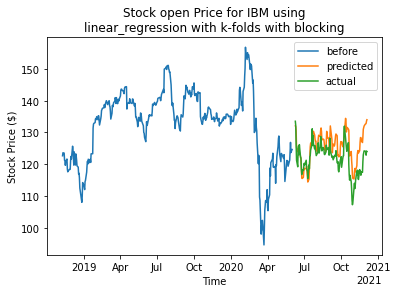

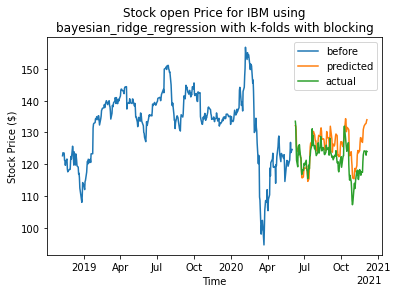

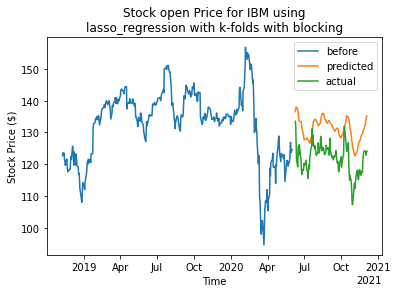

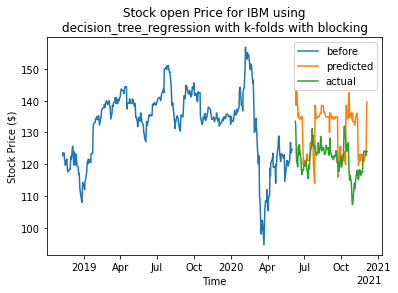

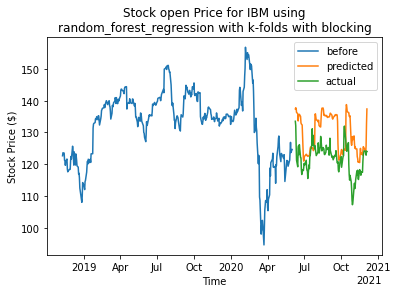

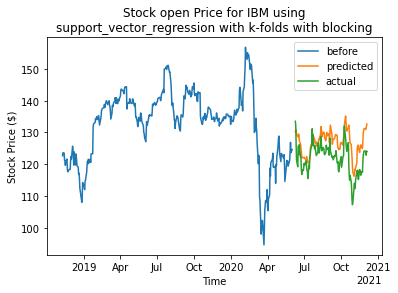

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

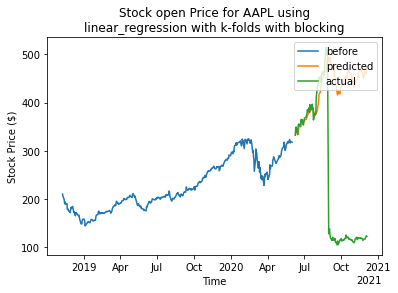

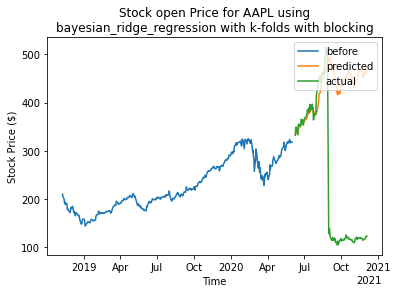

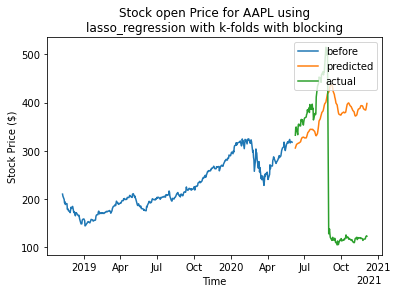

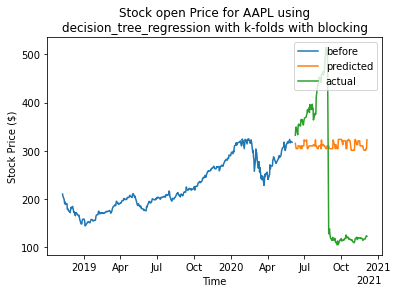

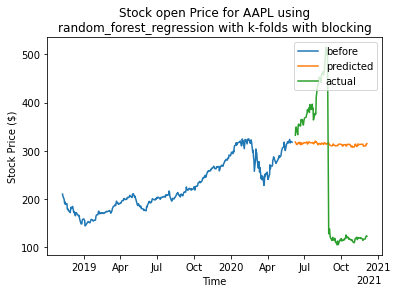

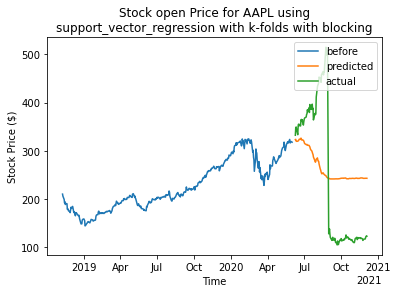

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

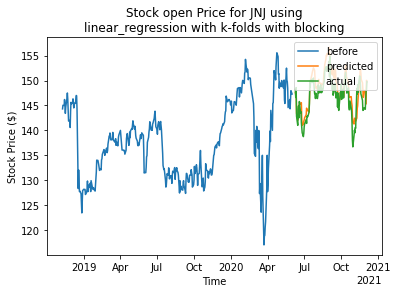

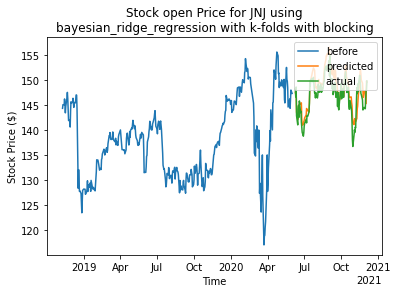

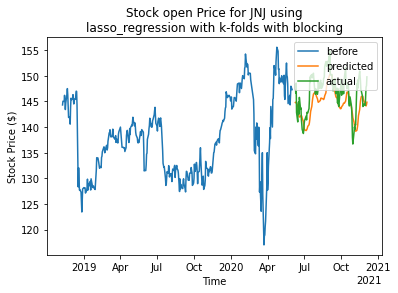

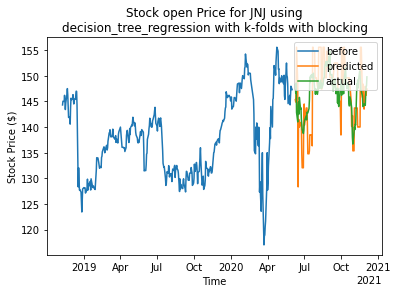

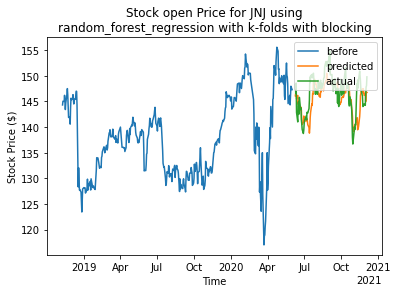

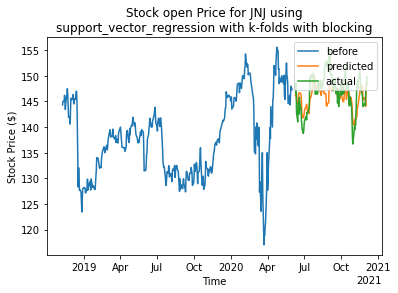

In [26]:
all_rmse, all_prediction = run_all(companies, price_types, model_types, k_folds=10, n_steps=5, PCA=True)

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

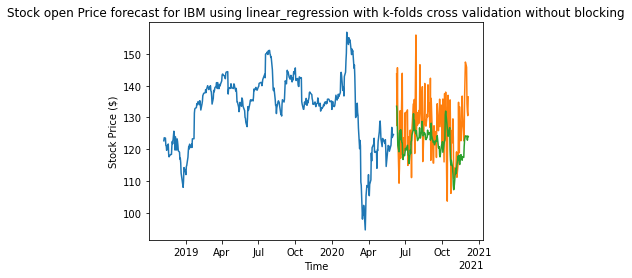

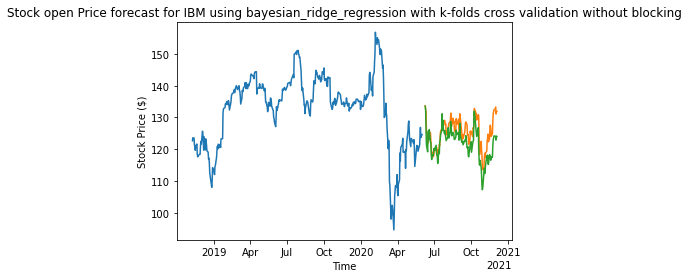

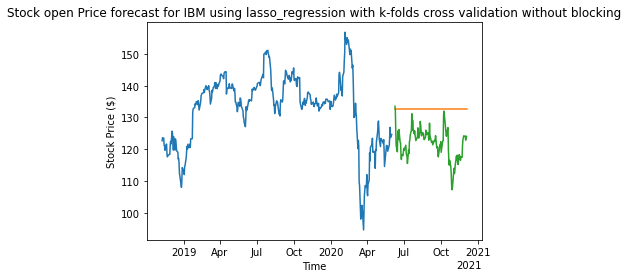

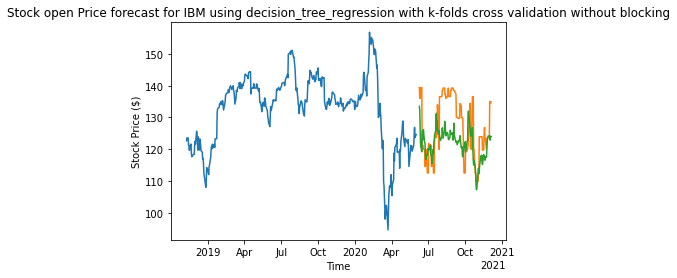

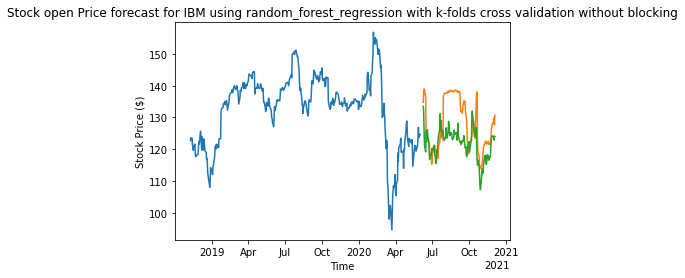

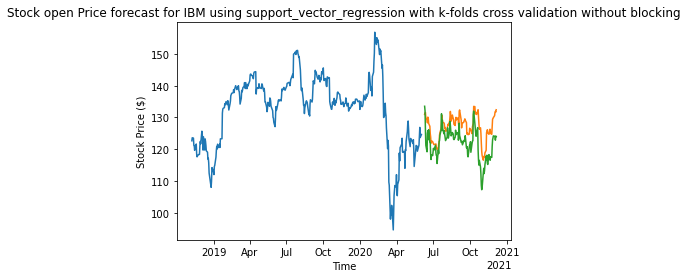

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

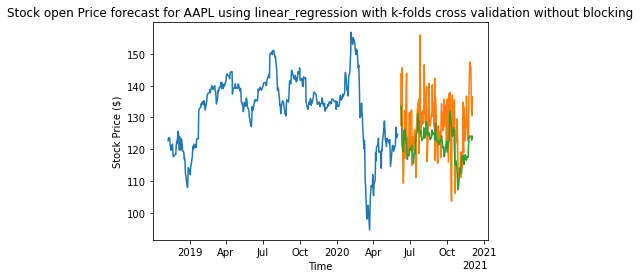

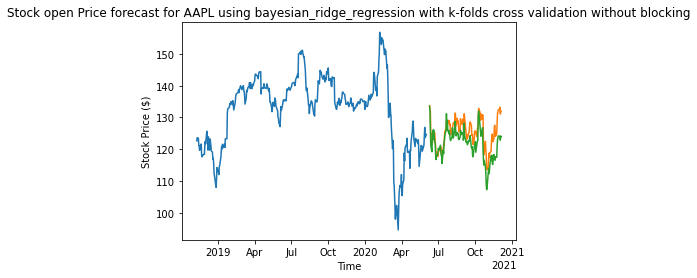

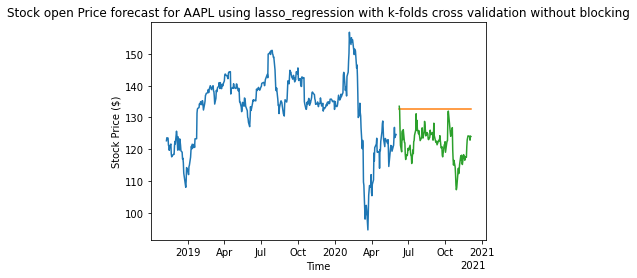

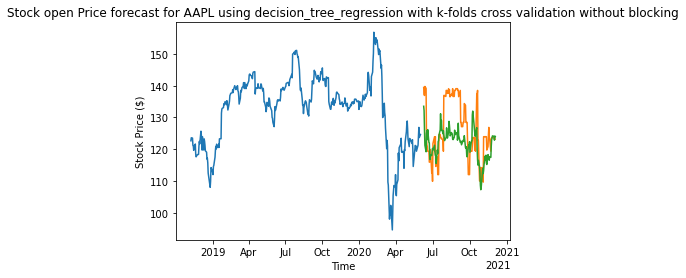

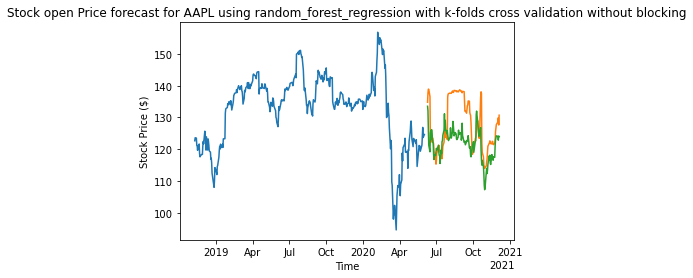

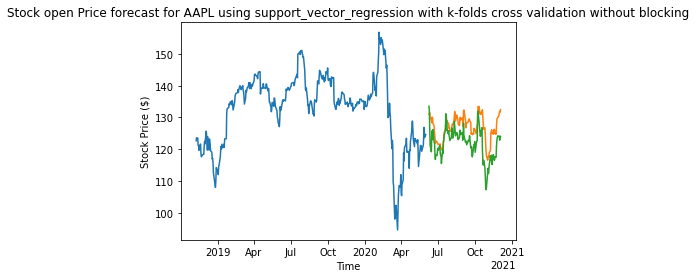

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

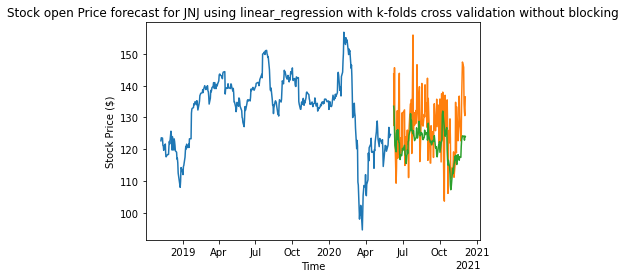

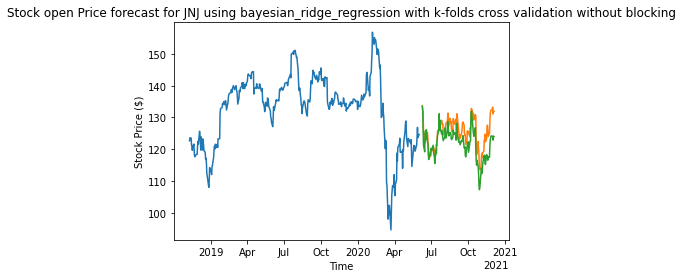

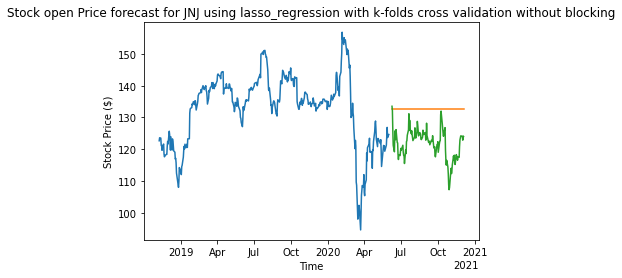

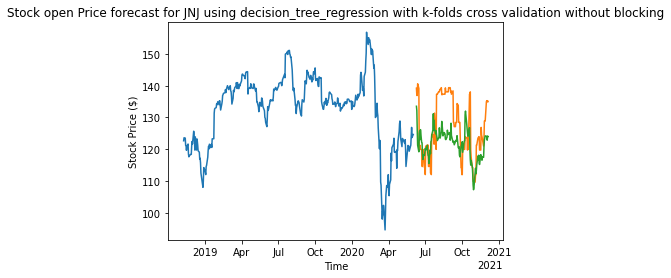

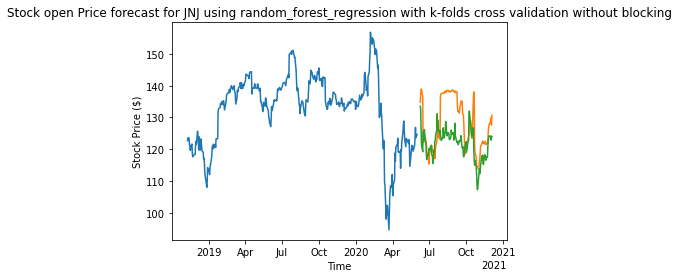

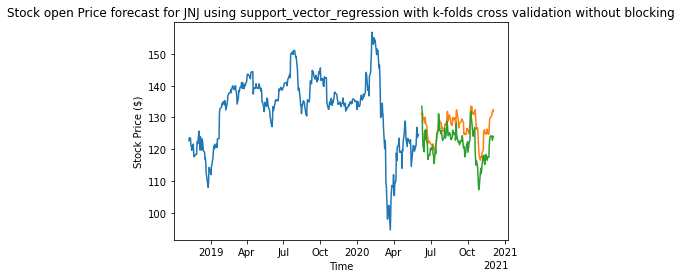

In [165]:
all_rmse_no_PCA, all_prediction_no_PCA = run_all(companies, price_types, model_types, k_folds=10, n_steps=5, PCA=False)

In [136]:
selected='IBM'

In [137]:
LSTM_data = pd.read_csv('./temp/LSTM_blocking_rmse.csv')
LSTM_data['open']

0    4.052180
1    3.847732
2    1.815942
3    3.713151
4    6.078049
5    2.759133
6    5.646661
7    8.640603
8    7.725238
9    4.416079
Name: open, dtype: float64

In [41]:
print("RMSEs for open price prediction")
LSTM_data = pd.read_csv('./temp/LSTM_blocking_rmse.csv')
blocking_rmse = all_rmse['IBM'][0]
blocking_rmse['LSTM'] = LSTM_data['open']
blocking_rmse.loc['mean'] = blocking_rmse.mean()

# shorten column names
blocking_rmse.drop('IBM', axis=1, inplace=True)
# blocking_rmse.columns = ['linear_reg', 'bayesian_ridge_reg', 'lasso_reg', 'decision_tree_reg', 'random_forest_reg', 'support_vector_reg', 'LSTM']
blocking_rmse

RMSEs for open price prediction


,linear_reg,bayesian_ridge_reg,lasso_reg,decision_tree_reg,random_forest_reg,support_vector_reg,LSTM
0,3.032341,2.973207,2.889588,5.236390,3.195479,2.766315,3.809931
1,1.651575,1.644621,4.028208,8.876527,7.959286,2.921372,4.527879
2,1.020808,1.013065,1.447584,3.115549,1.609019,1.309962,1.811945
3,2.288440,2.287018,4.997377,6.849540,5.794320,5.467515,3.772171
4,2.706423,2.699042,2.476286,4.787787,3.422274,6.460802,3.946628
5,2.415856,2.420106,9.695940,17.550870,14.582419,17.573037,4.898388
6,2.199421,2.201165,3.459656,6.441903,4.099366,2.397456,3.688728
7,11.508884,11.461069,8.202754,10.266262,9.996224,9.716127,8.859591
8,2.176218,2.209733,10.536865,10.557376,10.590664,10.186672,7.553288
9,5.238736,5.255670,9.990838,11.820291,9.928072,6.025175,5.019330


In [168]:
LSTM_data = pd.read_csv('./temp/LSTM_pca_no_pca_rmse.csv')
pca_no_pca = pd.DataFrame(columns = model_types)
with_pca = all_rmse[selected][0].loc[9].values[:-1]
no_pca = all_rmse_no_PCA[selected][0].loc[9].values
pca_no_pca.loc['with PCA'] = with_pca
pca_no_pca.loc['no PCA'] = no_pca
pca_no_pca['LSTM'] = LSTM_data['LSTM'].values
pca_no_pca.loc['absolute difference'] = abs(pca_no_pca.iloc[1,:]-pca_no_pca.iloc[0,:])

In [171]:
# shorten column names
pca_no_pca.columns = ['linear_reg', 'bayesian_ridge_reg', 'lasso_reg', 'decision_tree_reg', 'random_forest_reg', 'support_vector_reg', 'LSTM']
pca_no_pca

,linear_reg,bayesian_ridge_reg,lasso_reg,decision_tree_reg,random_forest_reg,support_vector_reg,LSTM
with PCA,5.238736,5.255670,9.990838,11.667019,9.928072,6.025175,4.416079
no PCA,10.437316,4.605439,11.991744,9.074535,8.717152,6.015950,6.612826
absolute difference,5.198581,0.650231,2.000906,2.592484,1.210919,0.009225,2.196747


In [181]:
all_rmse[selected][i].loc[9].values

array([ 5.23873556,  5.25567045,  9.99083794, 11.66701857,  9.92807165,
        6.02517523,  4.41607902])

In [90]:
selected='AAPL'
LSTM_data = pd.read_csv('./temp/LSTM_final_rmse.csv')
final_rmse = pd.DataFrame()
for i in range(len(price_types)):
    if 'LSTM' in all_rmse[selected][i].columns:
        all_rmse[selected][i].drop('LSTM', axis=1, inplace=True)
    all_rmse[selected][i].columns = ['linear_reg', 'bayesian_ridge_reg', 'lasso_reg', 'decision_tree_reg', 'random_forest_reg', 'support_vector_reg']
    final_rmse = pd.concat([final_rmse, all_rmse[selected][i].loc[[9]]], axis=0)
final_rmse.index = price_types
final_rmse['LSTM'] = LSTM_data['LSTM'].values
final_rmse

,linear_reg,bayesian_ridge_reg,lasso_reg,decision_tree_reg,random_forest_reg,support_vector_reg,LSTM
open,247.705588,247.576714,207.088619,160.200624,158.579838,130.059057,344.329495
close,248.452536,248.244175,207.001639,161.034401,159.230585,130.993021,329.303187
high,242.759030,242.887869,210.990076,162.093246,160.239230,132.099696,291.241962
low,235.959989,236.046037,203.075705,158.001064,157.342771,128.864515,322.989121


In [109]:
print("RMSEs for close price prediction")
all_rmse[selected][1]

RMSEs for close price prediction


,linear_regression,bayesian_ridge_regression,lasso_regression,decision_tree_regression,random_forest_regression,support_vector_regression
0,3.484558,3.400787,3.134302,5.841992,3.800438,4.017396
1,1.787189,1.793418,4.191569,10.428169,8.211732,3.268301
2,1.173099,1.162273,1.497262,2.475597,1.725808,1.461490
3,2.445740,2.443738,5.099340,6.674883,5.824036,5.879802
4,2.708124,2.691981,3.200833,4.359336,3.536246,6.179110
5,2.680810,2.687367,9.678293,14.415648,15.436136,17.960515
6,2.571773,2.551873,3.557747,8.613419,4.685330,2.671219
7,11.079447,11.034048,8.114984,9.336718,9.436665,9.484765
8,2.668464,2.711144,10.585368,9.795770,9.918615,10.880055
9,5.450626,5.466204,10.025662,11.111199,10.369667,6.013040


In [110]:
print("RMSEs for high price prediction")
rmse[2]

RMSEs for high price prediction


,linear_regression,bayesian_ridge_regression,lasso_regression,decision_tree_regression,random_forest_regression,support_vector_regression
0,2.997156,2.940083,3.070573,5.210391,3.540545,3.434623
1,1.653439,1.654929,3.929531,6.686058,7.918581,3.193584
2,1.065534,1.057568,1.463801,2.387300,1.587222,1.375378
3,2.221008,2.218719,5.129576,8.445818,6.323838,5.542462
4,2.588751,2.582186,2.648373,4.354266,3.507032,6.223044
5,2.509022,2.512507,9.671018,17.875793,15.001909,17.175375
6,2.319092,2.316116,3.562089,6.499013,4.227958,2.442433
7,11.498643,11.445402,8.222386,10.273974,9.510852,9.768031
8,2.335186,2.365797,10.550802,10.568439,10.131330,10.265661
9,5.282591,5.298958,10.037611,11.248187,10.178002,6.049455


In [111]:
print("RMSEs for low price prediction")
all_rmse[selected][3]

RMSEs for low price prediction


,linear_regression,bayesian_ridge_regression,lasso_regression,decision_tree_regression,random_forest_regression,support_vector_regression
0,2.899196,2.837899,3.041410,5.063873,3.035706,3.231878
1,1.740033,1.745387,4.167093,9.097542,8.114921,3.441064
2,1.065435,1.056636,1.440881,2.025754,1.599400,1.212842
3,2.231401,2.228903,4.870559,5.881389,5.618310,5.444823
4,2.878627,2.868060,3.246605,4.854572,3.858224,6.227787
5,2.627478,2.633248,9.777192,15.810216,15.914013,18.467513
6,2.545367,2.536362,3.495030,4.725497,4.195798,2.642645
7,11.094612,11.060574,8.124624,10.492867,9.623481,9.293526
8,2.399341,2.435192,10.496442,10.363476,9.668727,10.602277
9,5.580053,5.589038,9.974871,11.058408,10.022782,6.323850
